## Proyecto Final Propedéutico : Análisis de Rutas y Tiempos de Viaje.

In [119]:
library(dplyr)
library(ggplot2)
library(chron)
library(gmodels)
library(gridExtra)
library(IRdisplay)
library(dgof)
library(MASS)

### Lectura de datos y obtención de la duración de viaje

Debido a que los tiempos de retiro y arribo de bicicletas en la base de Mayo 2020 no incluyen los segundos, sino únicamente la hora y los minutos, mientras que en la base de Mayo 2019 se encuentra la información completa, se definió conservar únicamente las horas y minutos, y hacer los segundos iguales a cero en ambos casos. 

La imputación no es una opción, ya que toda la base de 2020 presenta este tipo de información incompleta.

Para el cálculo de la duración de viajes, fueron considerados únicamente los viajes que comenzaron y finalizaron el mismo día. Esta duración se reporta en minutos.

Se consideran cuatro tablas: `Mayo19` y `Mayo20`con el total de viajes para Mayo 2019 y 2020, y `Mayo19_filt` y `Mayo20_filt`  únicamente con los viajes de 45 minutos o menos.

In [120]:
#lectura de bases
Mayo19 = read.csv('Mayo19.csv') %>% mutate_if(is.factor,as.character)
Mayo20 = read.csv('Mayo20.csv') %>% mutate_if(is.factor,as.character)
colnames(Mayo20)[6]="Hora_Retiro"

#arreglo de tiempos
Mayo19$Hora_Retiro = substr(Mayo19$Hora_Retiro,1,5)
Mayo19$Hora_Arribo = substr(Mayo19$Hora_Arribo,1,5)
Mayo19$Hora_Retiro = paste(Mayo19$Hora_Retiro,":00",sep="")
Mayo19$Hora_Arribo = paste(Mayo19$Hora_Arribo,":00",sep="")
Mayo20$Hora_Retiro = paste(Mayo20$Hora_Retiro,":00",sep="")
Mayo20$Hora_Arribo = paste(Mayo20$Hora_Arribo,":00",sep="")

#formateo de tiempos
Mayo19$Hora_Arribo=chron(times=Mayo19$Hora_Arribo)
Mayo19$Hora_Retiro=chron(times=Mayo19$Hora_Retiro)
Mayo20$Hora_Arribo=chron(times=Mayo20$Hora_Arribo)
Mayo20$Hora_Retiro=chron(times=Mayo20$Hora_Retiro)

#conservar solo viajes comenzados y finalizados el mismo día (los casos en los que esto no ocurre presentan en muchos casos duraciones atipicas de hasta varios días)
Mayo19 = Mayo19 %>% filter(Fecha_Retiro == Fecha_Arribo,Ciclo_Estacion_Retiro<=480, Ciclo_Estacion_Arribo<=480)
Mayo20 = Mayo20 %>% filter(Fecha_Retiro == Fecha_Arribo,Ciclo_Estacion_Retiro<=480, Ciclo_Estacion_Arribo<=480)

#Duracion de viaje
Mayo19$Duracion = Mayo19$Hora_Arribo-Mayo19$Hora_Retiro
Mayo20$Duracion = Mayo20$Hora_Arribo-Mayo20$Hora_Retiro

#checar excedencias en el tiempo de viaje (mas de 45 mins)
Mayo19 = Mayo19 %>% mutate(Excedencia=ifelse((hours(Duracion)==0 & minutes(Duracion)<=45) | (hours(Duracion)==0 & (minutes(Duracion)+seconds(Duracion)/60<=45)),"NO","SI"))
Mayo20 = Mayo20 %>% mutate(Excedencia=ifelse((hours(Duracion)==0 & minutes(Duracion)<=45) | (hours(Duracion)==0 & (minutes(Duracion)+seconds(Duracion)/60<=45)),"NO","SI"))

#filtrar aquellos que no exceden los 45 mins permitidos
Mayo19_filt = Mayo19 %>% filter(Excedencia=="NO")
Mayo20_filt = Mayo20 %>% filter(Excedencia=="NO")

#pasar duracion a minutos
Mayo19 = Mayo19 %>% mutate(Duracion =  60*hours(Duracion) + minutes(Duracion))
Mayo20 = Mayo20 %>% mutate(Duracion =  60*hours(Duracion) + minutes(Duracion))
Mayo19_filt = Mayo19_filt %>% mutate(Duracion = minutes(Duracion))
Mayo20_filt = Mayo20_filt %>% mutate(Duracion = minutes(Duracion))

### Estaciones

Las estaciones de ecobici se identifican a través de números enteros, que van desde 1 hasta 480. El mapa y listado de cicloestaciones pueden consultarse en el siguiente [link](https://www.ecobici.cdmx.gob.mx/es/mapa-de-cicloestaciones).

Las bases utilizadas en este proyecto contienen información sobre la estación de retiro y arribo para cada uno de los viajes realizados.

Si bien el número de cicloestación funge únicamente como un identificador, visualizar histogramas normalizados de las distintas cicloestaciones de retiro y arribo y compararlas en el tiempo, puede dar evidencia gráfica de cambios en la movilidad.

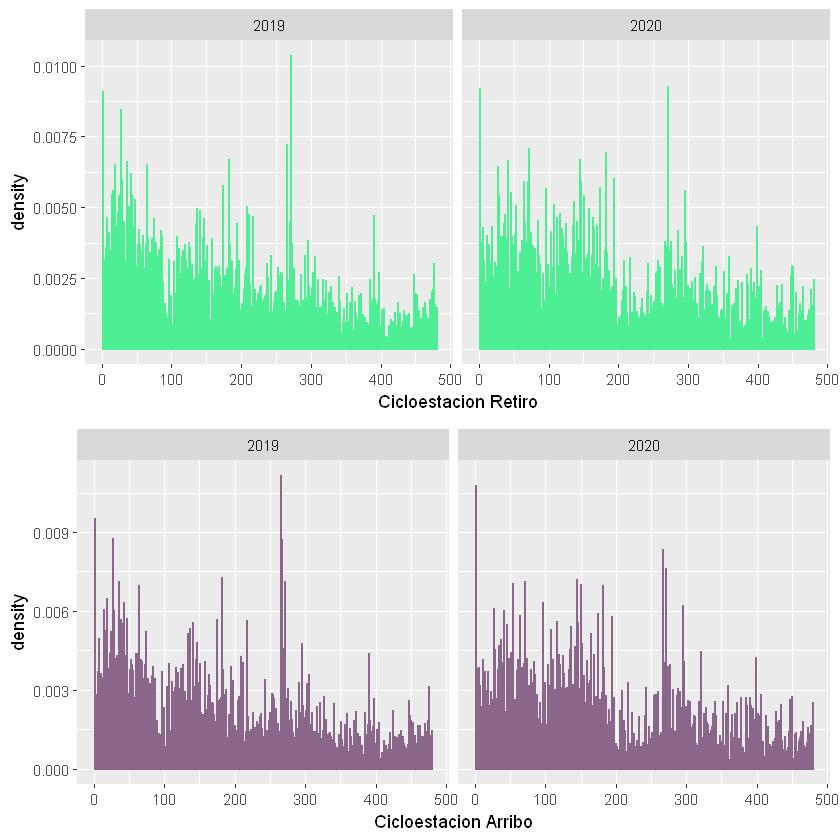

In [121]:
Mayo_filt = rbind(Mayo19_filt,Mayo20_filt) %>% mutate(Anio = substr(Fecha_Retiro,7,10))
retiro_plot = ggplot(Mayo_filt) + geom_histogram(aes(x=Ciclo_Estacion_Retiro,y=..density..),binwidth = 1,colour="seagreen2") + xlab("Cicloestacion Retiro") + facet_wrap(~Anio)
arribo_plot = ggplot(Mayo_filt) + geom_histogram(aes(x=Ciclo_Estacion_Arribo,y=..density..),binwidth = 1,colour="plum4") + xlab("Cicloestacion Arribo") + facet_wrap(~Anio)
grid.arrange(retiro_plot,arribo_plot,nrow=2,ncol=1)

Anualmente, el comportamiento general de los histogramas de retiro y arribo de biciletas por estación parece ser similar. Por otro lado, comparando los histogramas correspondientes a Mayo 2019 y Mayo 2020, se aprecian algunos cambios, unos más evidentes que otros. Por ejemplo, se tiene que en Mayo 2020 existe un incremento en la proporción de viajes realizados partiendo de y llegando a varias de las estaciones con numeración superior a 90 e inferior a 200, que se encuentran que zonas como la Roma, la colonia Juárez y Escandón.

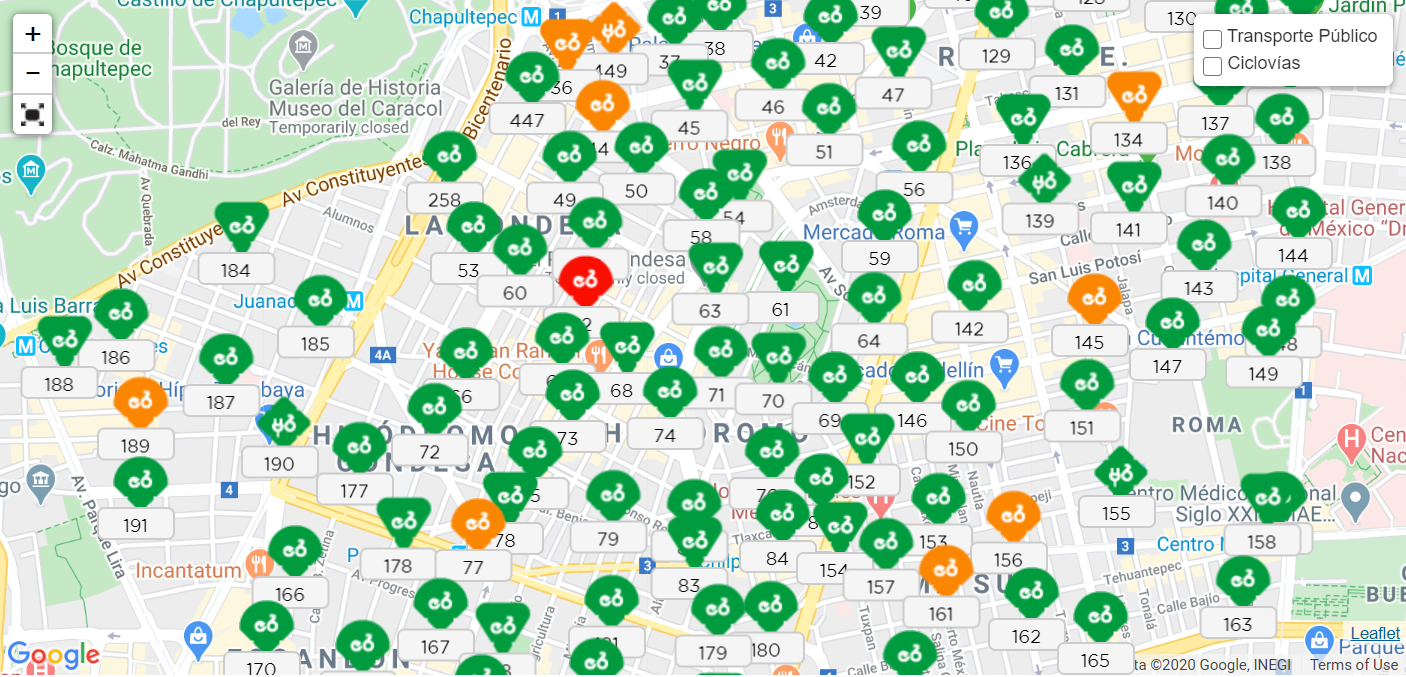

In [122]:
display_png(file="roma.png")   

Se tiene también un marcado descenso en la proporción de viajes que inician o finalizan en las estaciones numeradas entre 200 y 250 aproximadamente, rango correspondiente a colonias como Polanco y Anzures.

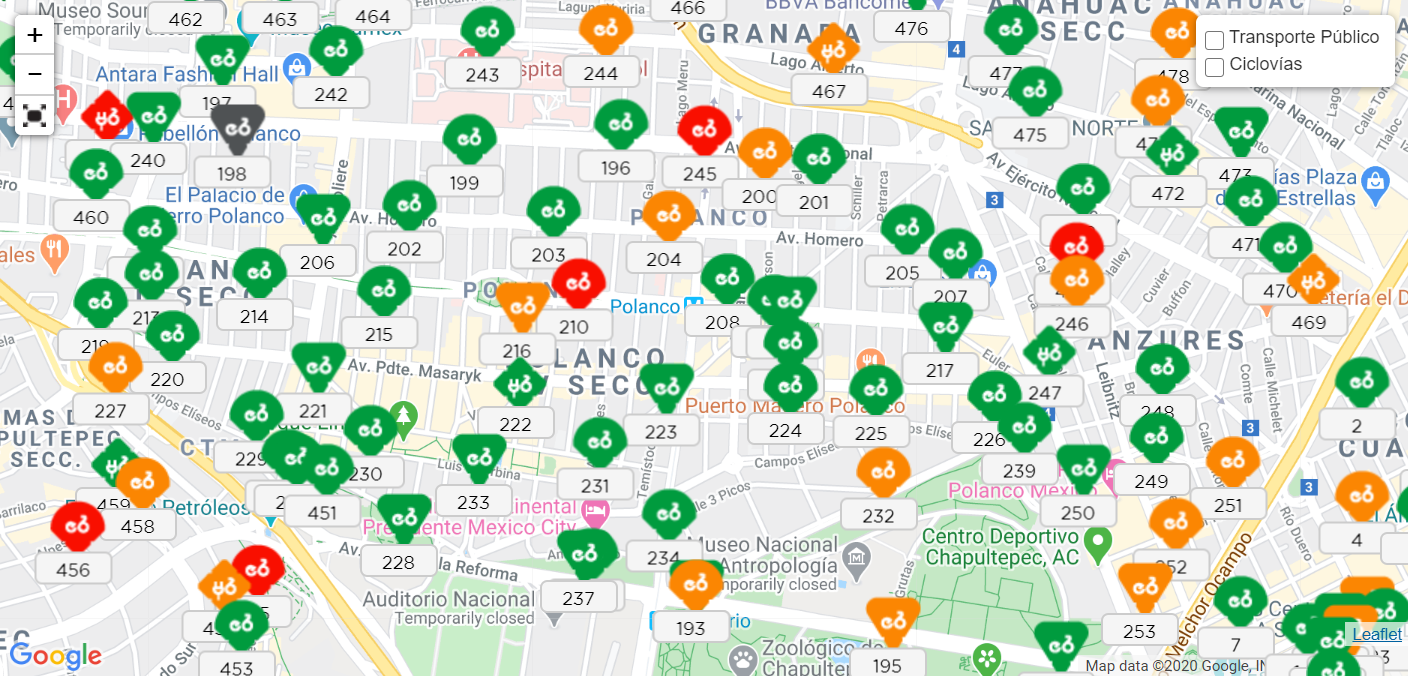

In [123]:
display_png(file="polanco.png") 

A continuación se presentan las cinco cicloestaciones donde se retiraron y donde arribaron más bicicletas en Mayo 2019 y Mayo 2020, así como una tabla que relaciona la numericación con la ubicación de las cicloestaciones más frecuentes.

In [124]:
count_retiro_t5 = Mayo_filt %>% group_by(Anio,Ciclo_Estacion_Retiro) %>% summarise(Freq_Retiro=n(),.groups = "drop") %>% group_by(Anio) %>% top_n(n = 5, wt = Freq_Retiro) %>% arrange(desc(Freq_Retiro))
count_arribo_t5 = Mayo_filt %>% group_by(Anio,Ciclo_Estacion_Arribo) %>% summarise(Freq_Arribo=n(),.groups = "drop") %>% group_by(Anio) %>% top_n(n = 5, wt = Freq_Arribo) %>% arrange(desc(Freq_Arribo))
count_t5=cbind(count_retiro_t5,count_arribo_t5[,-1])
count_t5

Anio,Ciclo_Estacion_Retiro,Freq_Retiro,Ciclo_Estacion_Arribo,Freq_Arribo
2019,271,7693,266,8278
2019,1,6729,1,7058
2019,27,6282,27,6503
2019,266,5353,267,6463
2019,182,4954,182,5408
2020,271,1369,1,1594
2020,1,1360,266,1233
2020,71,1048,271,1128
2020,182,1026,145,1066
2020,145,992,71,1055


In [125]:
df=data.frame(Ciclo_Estacion = unique(c(count_retiro_t5$Ciclo_Estacion_Retiro,count_arribo_t5$Ciclo_Estacion_Arribo))) %>% arrange(Ciclo_Estacion)
df$Ubicacion = c("RIO SENA-RIO BALSAS","REFORMA-HAVRE","AMSTERDAM-MICHOACAN","EJE 2 SUR YUCATÁN-CHIAPAS","PROGRESO-ASTRONOMOS","AV. JESÚS GARCIA-CARLOS J. MENESES","AV. JESÜS GARCÏA-CARLOS J. MENESES","AV. CENTRAL-J. MENESES")
df

Ciclo_Estacion,Ubicacion
1,RIO SENA-RIO BALSAS
27,REFORMA-HAVRE
71,AMSTERDAM-MICHOACAN
145,EJE 2 SUR YUCATÁN-CHIAPAS
182,PROGRESO-ASTRONOMOS
266,AV. JESÚS GARCIA-CARLOS J. MENESES
267,AV. JESÜS GARCÏA-CARLOS J. MENESES
271,AV. CENTRAL-J. MENESES


Las cicloestaciones 1, 182, 266 y 271 permanecen entre las más usadas en ambos años. La estación 27, localizada en el corazón de la avenida Reforma, dejó de ser de las más frecuentemente utilizadas. Por otro lado, estaciones como la 71 y 145, respecticamente en las colonias Condesa y Roma, fueron de las más visitadas tanto como punto de inicio y de término de viaje en 2020, pero no en 2019.

De acuerdo al mapa, las estaciones 266, 267 y 271 se encuentran a poco metros de distancia una de otra, y son algunas de aquellas que se encuentran más al norte de la CMDX. Adicionalmente, se localizan una cuadra de Insurgentes Norte y de Forum Buenavista, estando cerca de medios de transporte público tales como el metrobús, el tren suburbano, y las estaciones de metro Revolución y Guerrero.

En la tabla siguiente se comparan de forma separada las frequencias de las estaciones 71 y 145, y de las estaciones 1, 27, 182, 266, 267 y 271, en Mayo 2019 y Mayo 2020.

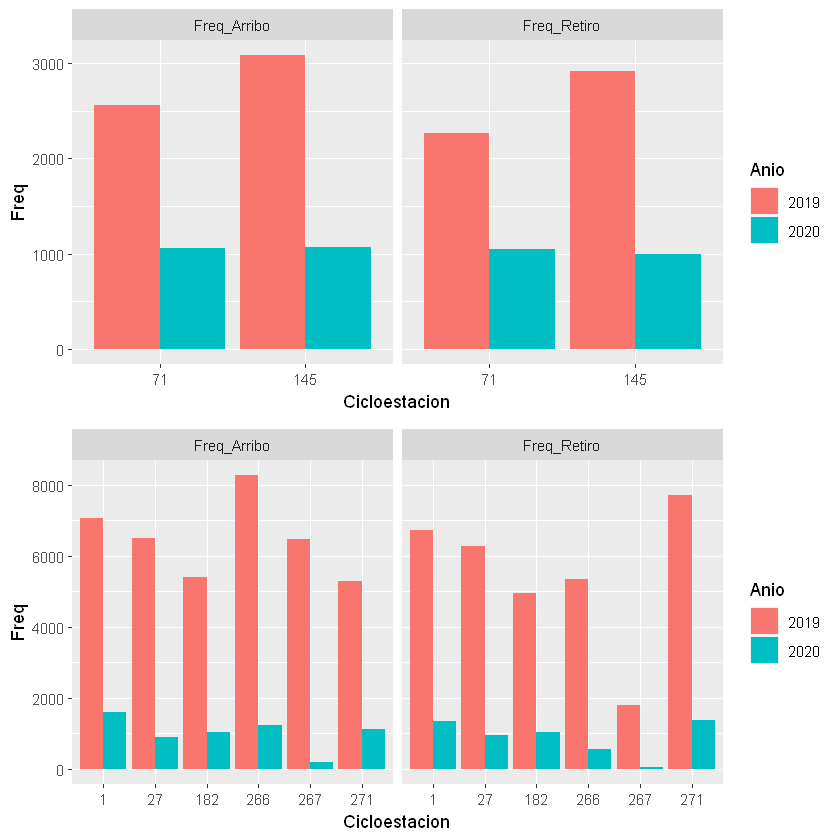

In [126]:
count_retiro = Mayo_filt %>% group_by(Anio,Ciclo_Estacion_Retiro) %>% summarise(Freq_Retiro=n(),.groups = "drop") 
count_arribo = Mayo_filt %>% group_by(Anio,Ciclo_Estacion_Arribo) %>% summarise(Freq_Arribo=n(),.groups = "drop") 
count1 = count_retiro[which(count_retiro$Ciclo_Estacion_Retiro %in% c(71,145)),]
count2 = count_arribo[which(count_arribo$Ciclo_Estacion_Arribo %in% c(71,145)),]
count=cbind(count1,count2[,-1])[,-4] %>% rename(Ciclo_Estacion = Ciclo_Estacion_Retiro)
count$i=1:4
count$Ciclo_Estacion = as.factor(count$Ciclo_Estacion)
p1=reshape(data = count,varying = c("Freq_Retiro","Freq_Arribo"),direction="long",v.name=c("value"),times=c("Freq_Retiro","Freq_Arribo"),idvar="i" ) %>%
ggplot(aes(fill=Anio, y=value, x=Ciclo_Estacion)) + 
    geom_bar(position="dodge", stat="identity") + facet_wrap(~time) + xlab("Cicloestacion") + ylab("Freq")

count_retiro = Mayo_filt %>% group_by(Anio,Ciclo_Estacion_Retiro) %>% summarise(Freq_Retiro=n(),.groups = "drop") 
count_arribo = Mayo_filt %>% group_by(Anio,Ciclo_Estacion_Arribo) %>% summarise(Freq_Arribo=n(),.groups = "drop") 
count1 = count_retiro[which(count_retiro$Ciclo_Estacion_Retiro %in% c(1,27, 182, 266, 267, 271)),]
count2 = count_arribo[which(count_arribo$Ciclo_Estacion_Arribo %in% c(1,27, 182, 266, 267, 271)),]
count=cbind(count1,count2[,-1])[,-4] %>% rename(Ciclo_Estacion = Ciclo_Estacion_Retiro)
count$i=1:12
count$Ciclo_Estacion = as.factor(count$Ciclo_Estacion)
p2=reshape(data = count,varying = c("Freq_Retiro","Freq_Arribo"),direction="long",v.name=c("value"),times=c("Freq_Retiro","Freq_Arribo"),idvar="i" ) %>%
ggplot(aes(fill=Anio, y=value, x=Ciclo_Estacion)) + 
    geom_bar(position="dodge", stat="identity") + facet_wrap(~time) + xlab("Cicloestacion") + ylab("Freq") 

grid.arrange(p1,p2,ncol=1)

Mientras que las estaciones 71 y 145 experimentaron reducciones de entre un 50% y 65% en las frecuencias de uso tanto en retiros como en arribos, las estaciones 1, 27, 182, 266, 267 y 271 presentaron disminuciones mucho mayores.

Resulta también de interés identificar si se presentan variaciones en la distribución del uso de estaciones de retiro y arribo en distintos grupos de edad y genero, considerando las observaciones de ambos años.

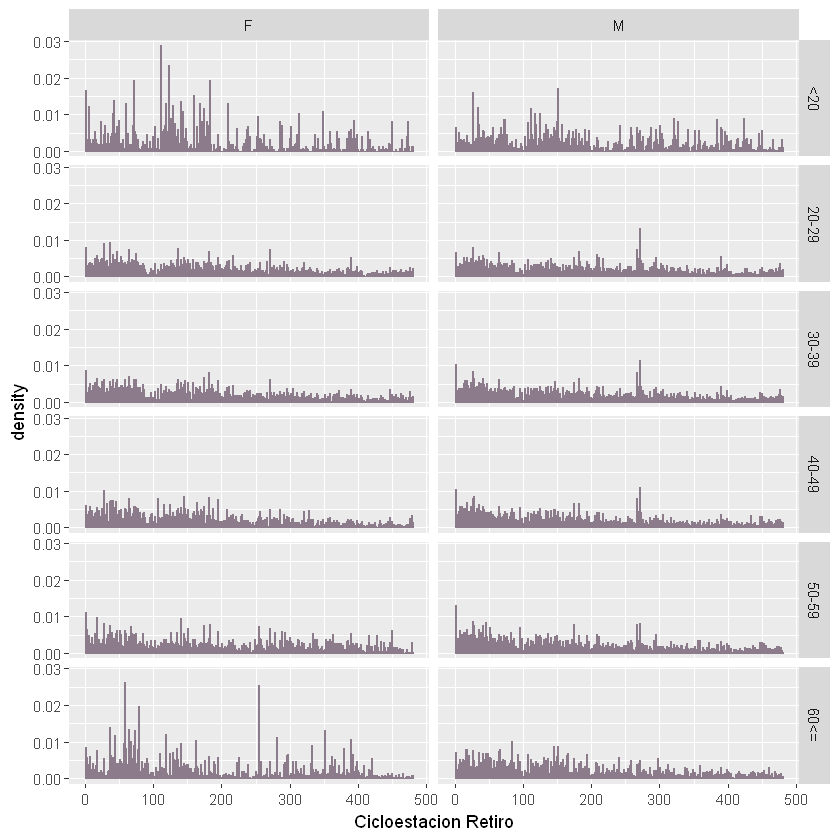

In [132]:
retiro_plot_all = Mayo_filt %>% mutate(Edad=ifelse(Edad_Usuario<20,"<20",ifelse(Edad_Usuario<30,"20-29",ifelse(Edad_Usuario<40,"30-39",ifelse(Edad_Usuario<50,"40-49",ifelse(Edad_Usuario<60,"50-59","60<=")))))) %>% ggplot() + geom_histogram(aes(x=Ciclo_Estacion_Retiro,y=..density..),binwidth = 1,colour="thistle4") + xlab("Cicloestacion Retiro") + facet_grid(Edad~Genero_Usuario)
retiro_plot_all

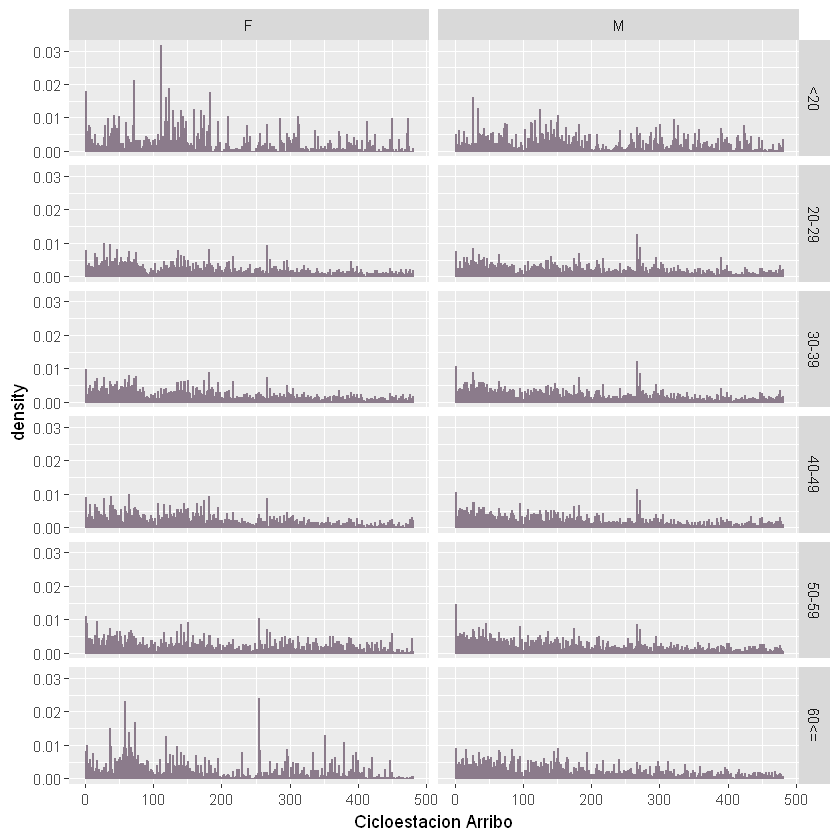

In [134]:
arribo_plot_all = Mayo_filt %>% mutate(Edad=ifelse(Edad_Usuario<20,"<20",ifelse(Edad_Usuario<30,"20-29",ifelse(Edad_Usuario<40,"30-39",ifelse(Edad_Usuario<50,"40-49",ifelse(Edad_Usuario<60,"50-59","60<=")))))) %>% ggplot() + geom_histogram(aes(x=Ciclo_Estacion_Arribo,y=..density..),binwidth = 1,colour="thistle4") + xlab("Cicloestacion Arribo") + facet_grid(Edad~Genero_Usuario)
arribo_plot_all

### Rutas

Cada pareja de números determinada por una cicloestación de retiro y una de arribo, representa una ruta recorrida. Existen registros de usuarios cuya estacion de retiro y arribo son la misma, lo cual casi siempre se relaciona con una duración de viaje extremadamente corto, dado que el usuario muy probablemente regresó la bicicleta debido a al munfuncionamiento o algún cambio de opinión respecto al viaje.

In [73]:
glimpse(Mayo20)

Rows: 152,766
Columns: 11
$ Genero_Usuario        <chr> "M", "M", "M", "M", "M", "M", "M", "M", "M", ...
$ Edad_Usuario          <int> 44, 33, 30, 29, 46, 39, 34, 27, 19, 30, 20, 3...
$ Bici                  <chr> "2570", "7849", "8624", "8659", "10275", "110...
$ Ciclo_Estacion_Retiro <int> 24, 4, 12, 171, 287, 156, 234, 143, 167, 295,...
$ Fecha_Retiro          <chr> "01/05/2020", "01/05/2020", "01/05/2020", "01...
$ Hora_Retiro           <times> 00:00:00, 00:01:00, 00:06:00, 00:07:00, 00:...
$ Ciclo_Estacion_Arribo <int> 183, 4, 1, 330, 288, 80, 270, 70, 166, 136, 4...
$ Fecha_Arribo          <chr> "01/05/2020", "01/05/2020", "01/05/2020", "01...
$ Hora_Arribo           <times> 00:08:00, 00:05:00, 00:10:00, 00:13:00, 00:...
$ Duracion              <dbl> 8, 4, 4, 6, 3, 3, 25, 10, 2, 12, 40, 3, 7, 7,...
$ Excedencia            <chr> "NO", "NO", "NO", "NO", "NO", "NO", "NO", "NO...


FALTA AÑADIR AQUI

### Duración de Viaje

A partir de las observaciones correspondientes a viajes regulares (de 45 minutos o menos), se obtienen los siguientes resúmenes, histogramas y boxplots, comparando entre Mayo 2019 y Mayo 2020. A través de estas herramientas descriptivas es posible notar que si bien algunos extadísticos son iguales (como la mediana por ejemplo) los valores del primer y tercer cuartil, así como la desviación estándar, dan evidencia de que la distribución de la duración de viajes regulares en Mayo 2020 presenta una mayor dispersión.

In [35]:
#data.frame(summary(Mayo19_filt))
x = summary(Mayo19_filt$Duracion)
x=data.frame(x=matrix(x),row.names=names(x))
y= summary(Mayo20_filt$Duracion)
y=data.frame(y=matrix(y),row.names=names(y))
df=cbind(x,y) %>% rename(`Duracion_2019`=x,`Duracion_2020`=y)
z= data.frame(Duracion_2019=sd(Mayo19_filt$Duracion),Duracion_2020=sd(Mayo20_filt$Duracion))
df = rbind(df,z)
rownames(df)[7] = "Std. Dev."
df

,Duracion_2019,Duracion_2020
Min.,0.00000,0.00000
1st Qu.,7.00000,6.00000
Median,11.00000,11.00000
Mean,13.03419,13.75468
3rd Qu.,17.00000,19.00000
Max.,45.00000,45.00000
Std. Dev.,8.48280,10.26561


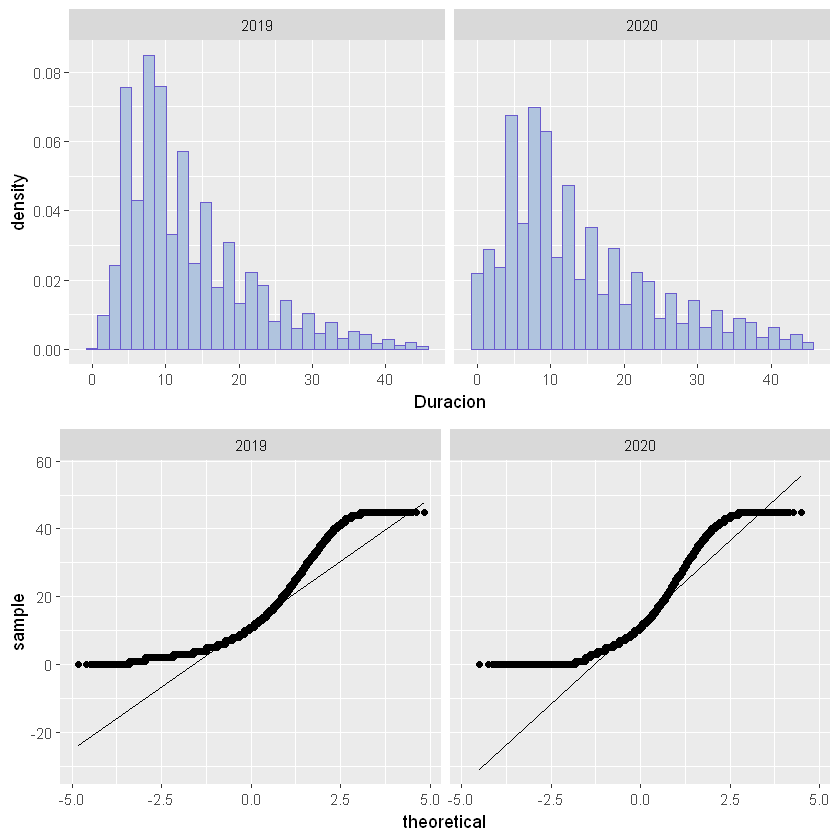

In [36]:
pl1 = Mayo_filt %>% ggplot(aes(group=Anio)) + geom_histogram(aes(x=Duracion,y=..density..),colour="slateblue",bins=30,fill="lightsteelblue") + facet_wrap(~Anio)
pl2 = Mayo_filt %>% ggplot(aes(sample = Duracion)) +  stat_qq(distribution = stats::qnorm) + stat_qq_line(distribution = stats::qnorm) + facet_wrap(~Anio)
grid.arrange(pl1,pl2)

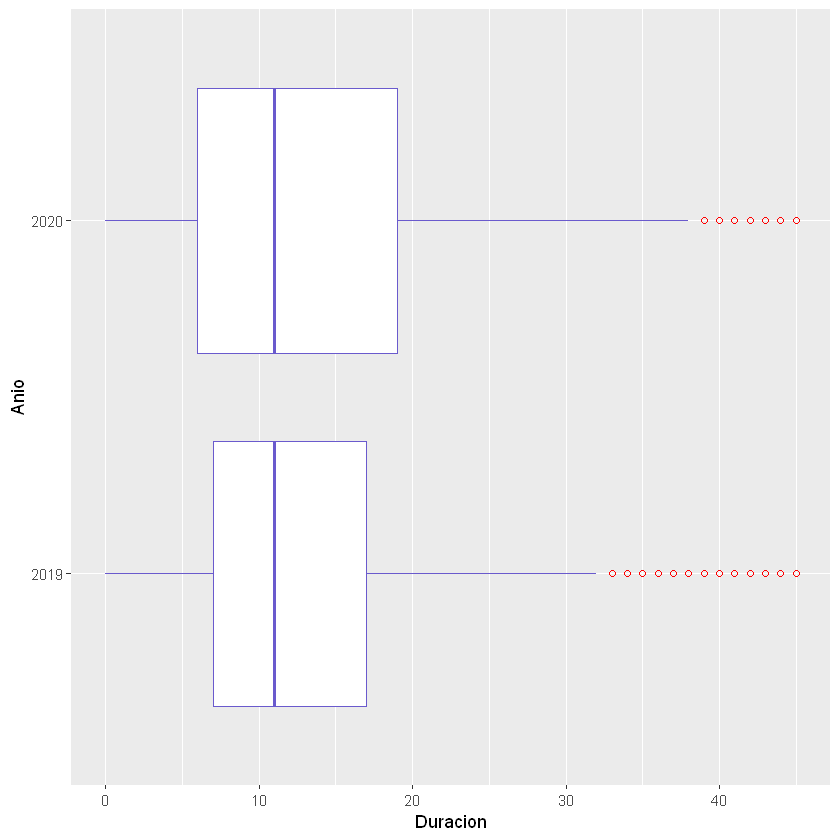

In [37]:
Mayo_filt %>% ggplot(aes(group=Anio)) + geom_boxplot(aes(x=Duracion,y=Anio),colour="slateblue",outlier.colour = "red", outlier.shape = 1)
  #theme(axis.title.x=element_blank(),
   #     axis.text.x=element_blank(),
    #    axis.ticks.x=element_blank())

Resulta interesante cuestionar si la duración promedio de los viajes en Mayo 2020 es de hecho mayor que la duración promedio en Mayo 2019.

Debido al tamaño de muestra grande, resulta razonable aplicar la prueba T de Welch para dos muestras, en la cual se pretende contrastar
$$
H_0: \quad \mu_{2019} - \mu_{2020} = 0 \qquad \text{vs} \qquad H_1: \quad \mu_{2019} - \mu_{2020} \neq 0
$$

A diferencia de la prueba T de Student, la T de Welch no supone igualdad de varianzas, aunque el supuesto de normalidad sigue manteniéndose. Existen procedimientos para probar la igualdad de varianzas, tal como el test de Levene. Sin embargo, algunos autores sugieren que no es conveniente aplicar tales con la finalidad de decidir si se usará la prueba de Student o de Welch, ya que el tamaño de la prueba (la probabilidad máxima de cometer un error tipo I) puede ser distorsionado:

*Zimmerman, D. W. (2004). A note on preliminary tests of equality of variances. British Journal of Mathematical and Statistical Psychology, 57(1), 173–181.* [Ref.](https://doi.org/10.1348/000711004849222)

Dado que la prueba T de Welch tiene una potencia casi tan alta como la prueba T de Student bajo el supuesto de homogeneidad de varianzas, y retiene mayor potencia cuando dicho supuesto es violado, es recomendable aplicar el test de Welch diractamente sin verificar la homogeneidad previamente.

Adicionalmente, la prueba de Welch es moderadamente robusta a la violación de normalidad siempre que el sesgo no sea muy grande.

La prueba de Welch se lleva a cabo utilizando la funcion `t.test` de `R`, y el resultado de presenta a continuacion.

In [38]:
t.test(x=Mayo19_filt$Duracion,y=Mayo20_filt$Duracion)


	Welch Two Sample t-test

data:  Mayo19_filt$Duracion and Mayo20_filt$Duracion
t = -25.299, df = 189844, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7763107 -0.6646745
sample estimates:
mean of x mean of y 
 13.03419  13.75468 


La prueba de dos colas es rechazada al nivel $0.05$ se significancia.

Esta prueba posee versión de una cola, en la cual las hipótesis pueden plantearse como

$$
H_0: \quad \mu_{2019} - \mu_{2020} \geq 0 \qquad \text{vs} \qquad H_1: \quad \mu_{2019} - \mu_{2020} < 0
$$
 
Esta prueba se lleva a cabo con la misma función `t.test`, empleando el argumento `alternative="less"`.

In [40]:
t.test(x=Mayo19_filt$Duracion,y=Mayo20_filt$Duracion,alternative = "less")


	Welch Two Sample t-test

data:  Mayo19_filt$Duracion and Mayo20_filt$Duracion
t = -25.299, df = 189844, p-value < 2.2e-16
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.6736487
sample estimates:
mean of x mean of y 
 13.03419  13.75468 


Usando nuevamente un nivel de significancia de $0.05$, se rechaza $H_0$ en favor de la hipótesis de que la media de la duración de viajes regulares en Mayo 2020 es mayor que la de Mayo 2019.

Dada la no normalidad de los datos, otra prueba que es conveniente aplicar es el test no paramétrico de Mann–Whitney–Wilcoxon, que no posee supuestos distribucionales. Este test es aplicable cuando se tienen muestras independientes, y nos permite investigar si dos muestras provienen de la misma distribución.

La funcion `wilcox.test` en `R` permite contrastar la hipótesis.

In [44]:
wilcox.test(x=Mayo19_filt$Duracion,y=Mayo20_filt$Duracion,paired = FALSE)


	Wilcoxon rank sum test with continuity correction

data:  Mayo19_filt$Duracion and Mayo20_filt$Duracion
W = 5.4484e+10, p-value = 0.05613
alternative hypothesis: true location shift is not equal to 0


En este caso, la hipótesis de igualdad de distribucion de la duración en Mayo 2019 y 2020, no es rechazada al nivel de significancia 0.05.

Para cada usuario, la duración de viaje puede ser influida por un gran número de factores. Entre las variables de interés que se tienen en la base, se encuentran el género, y la edad dividida por grupos. 

Graficamente, histogramas o densidades estimadas, así como boxplots, pueden proporcionar una idea de la variación de la duración en los distintos grupos definidos por género, grupo de edad, y año.

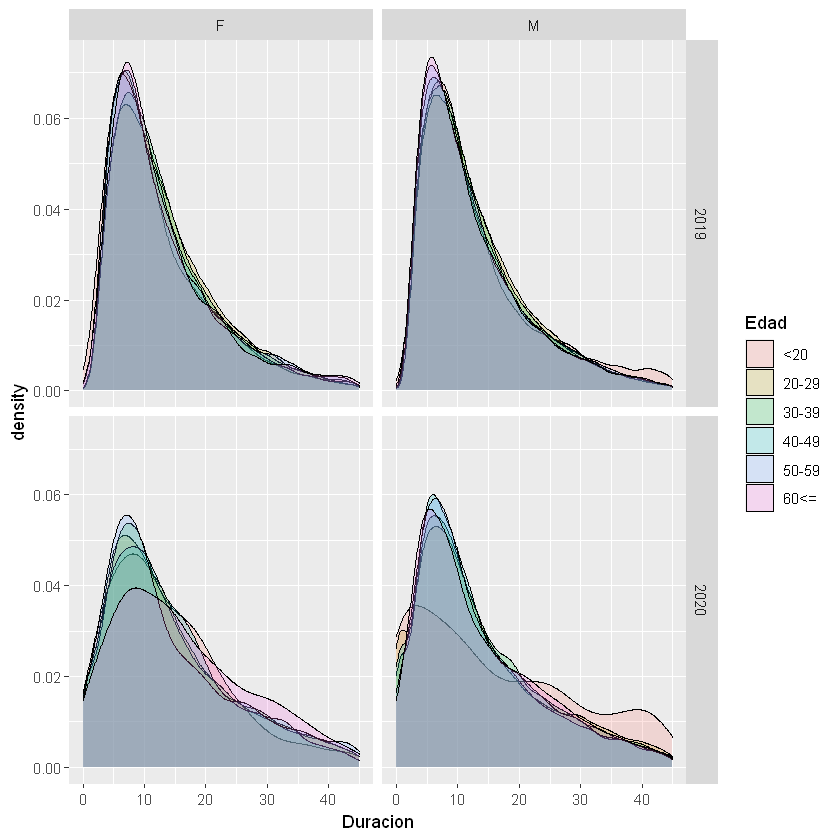

In [98]:
Mayo_filt %>% mutate(Edad=ifelse(Edad_Usuario<20,"<20",ifelse(Edad_Usuario<30,"20-29",ifelse(Edad_Usuario<40,"30-39",ifelse(Edad_Usuario<50,"40-49",ifelse(Edad_Usuario<60,"50-59","60<=")))))) %>%
ggplot(aes()) + geom_density(aes(x=Duracion,fill=Edad),alpha=0.2) + facet_grid(Anio~Genero_Usuario)

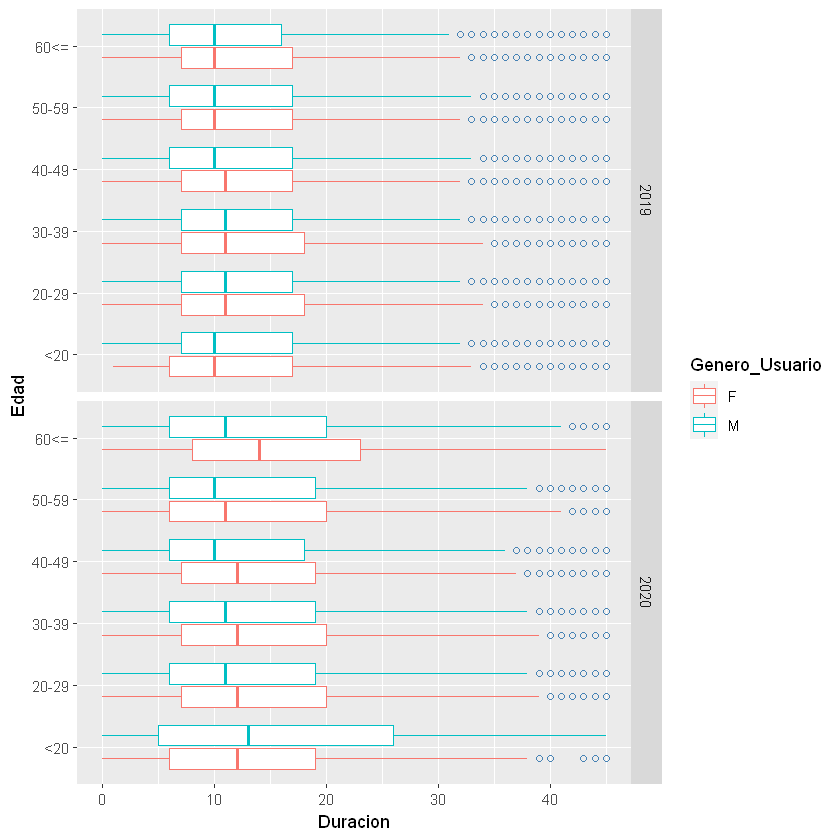

In [99]:
Mayo_filt %>% mutate(Edad=ifelse(Edad_Usuario<20,"<20",ifelse(Edad_Usuario<30,"20-29",ifelse(Edad_Usuario<40,"30-39",ifelse(Edad_Usuario<50,"40-49",ifelse(Edad_Usuario<60,"50-59","60<=")))))) %>%
ggplot(aes()) + geom_boxplot(aes(x=Duracion,y=Edad,colour=Genero_Usuario),outlier.colour = "steelblue", outlier.shape = 1) + facet_grid(rows = vars(Anio))

Debido a que el mes de Mayo de 2020 es anómalo debido a la pandemia por coronavirus, y en consecuencia la base presenta menos observaciones y refleja un comportamiento posiblemente inusual, es una buena idea analizar la variabilidad de la duración de viaje utilizando la base de Mayo 2019.

Un método muy utilizado para medir el efecto que tienen algunos factores (en este caso el género y grupo de edad) sobre una variable cuantitativa (la duración de viaje), es el de análisis de varianza (ANOVA), en el cual se modela el vector respuesta $\vec{Y}$ como
$$
\vec{Y} = X\vec{\beta} + \vec{\varepsilon}
$$

con $\vec{\beta}$ un vector de coeficientes, $X$ una matriz de diseño que contiene la información sobre los factores y $\vec{\varepsilon}$ un vector aleatorio de errores, centrado ($\vec{\mu}=\vec{0}$) y con matriz de covarianzas esférica $\Sigma = \sigma^2 I $. Si se supone una distribución normal multivariada para el vector de errores, es posible probar estadísticamente si los factores contribuyen a explicar la variabilidad de la variable respuesta, a través de estadísticos sencillos dados en términos de cocientes entre sumas de cuadrados medias, que resultan tener distribuciones $F$.

El modelo puede ajusarse utilizando la funcion `lm`, que construye variables auxiliares, también llamadas "dummy", para la construcción de la matriz de diseño y el ajuste. Debido a que el modelo de análisis de varianza es por construcción de rango incompleto, no existe una solución única a las ecuaciones normales. Por ello se hacen cero los coeficientes asociados al primer nivel de cada factor, y posteriormente se encuentra una solución única bajo esta restricción. A pesar de que las ecuaciones normales para modelos de rango incompleto tienen una infinidad de soluciones, los valores ajustados, residuales, y demás estadísticos relevantes tales como sumas de cuadrados medias, sí resultan ser únicos.

Si bien es evidente que no se tiene normalidad dentro de los grupos, debido a la robustez del ANOVA frente a la no normalidad y sesgo moderado, es conveniente aplicarlo y observar la tabla de análisis de varianza obtenida, recordardo que los p-values serán conservadores.

In [109]:
Mayo_an =Mayo19_filt %>% mutate(Edad=ifelse(Edad_Usuario<20,"<20",ifelse(Edad_Usuario<30,"20-29",ifelse(Edad_Usuario<40,"30-39",ifelse(Edad_Usuario<50,"40-49",ifelse(Edad_Usuario<60,"50-59","60<=")))))) 
m1= lm(formula=Duracion ~ Genero_Usuario + Edad + Genero_Usuario*Edad ,data=Mayo_an)

In [110]:
summary(m1)


Call:
lm(formula = Duracion ~ Genero_Usuario + Edad + Genero_Usuario * 
    Edad, data = Mayo_an)

Residuals:
    Min      1Q  Median      3Q     Max 
-13.622  -6.399  -2.124   4.115  32.562 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                12.4384     0.1988  62.558  < 2e-16 ***
Genero_UsuarioM             0.9687     0.2327   4.162 3.15e-05 ***
Edad20-29                   1.1839     0.2011   5.886 3.96e-09 ***
Edad30-39                   0.9609     0.2014   4.771 1.83e-06 ***
Edad40-49                   0.5000     0.2068   2.418  0.01561 *  
Edad50-59                   0.6614     0.2139   3.092  0.00199 ** 
Edad60<=                    0.6086     0.2476   2.458  0.01398 *  
Genero_UsuarioM:Edad20-29  -1.4671     0.2356  -6.228 4.74e-10 ***
Genero_UsuarioM:Edad30-39  -1.4830     0.2356  -6.293 3.11e-10 ***
Genero_UsuarioM:Edad40-49  -1.1327     0.2411  -4.698 2.63e-06 ***
Genero_UsuarioM:Edad50-59  -1.4319     0.2488  -5.756 8

In [111]:
anova(m1)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Genero_Usuario,1,33917.000,33916.99961,471.90834,1.328251e-104
Edad,5,25917.335,5183.46701,72.12080,9.518086e-76
Genero_Usuario:Edad,5,4555.479,911.09574,12.67664,2.427811e-12
Residuals,740468,53218921.599,71.87201,NA,NA


De acuerdo a la tabla ANOVA, los factores género y grupo de edad contribuyen a explicar la variabilidad de la duración de viaje, y la interacción de ambos factores también en estadísticamente significativa.

Una alternativa no paramétrica al análisis de varianza para el caso de un factor explicativo, es la prueba de Kruskal-Wallis, que es de hecho una extensión del test de Mann–Whitney–Wilcoxon a tres grupos o más. Esta prueba está disponible en `R` a través de la función `kruskal.test`.

Si bien la prueba de Kruskal-Wallis no es aplicable a dos o más factores simultáneamente tal como el caso de ANOVA, es una herramienta que permite investigar si la duración de los viajes difiere significativamente con el género y con el grupo de edad.

A continuación se realiza el contraste de hipótesis para ambos factores de interés.

In [117]:
kruskal.test(Duracion ~ Genero_Usuario, data = Mayo_an)


	Kruskal-Wallis rank sum test

data:  Duracion by Genero_Usuario
Kruskal-Wallis chi-squared = 780.07, df = 1, p-value < 2.2e-16


In [118]:
kruskal.test(Duracion ~ Edad, data = Mayo_an)


	Kruskal-Wallis rank sum test

data:  Duracion by Edad
Kruskal-Wallis chi-squared = 939.91, df = 5, p-value < 2.2e-16


En ambos casos los p-values son estadísticamente significativos, por lo cual se concluye que la duración de los viajes en ecobici difiere con el género del usuario, y también difiere con el grupo de edad.

Dada la conclusión anterior dada por la prueba de Welch, sobre la duración mayor de los viajes en Mayo 2020, es de interés investigar si una mayor proporción de gente realizó viajes superiores a los 45 minutos en Mayo 2020.

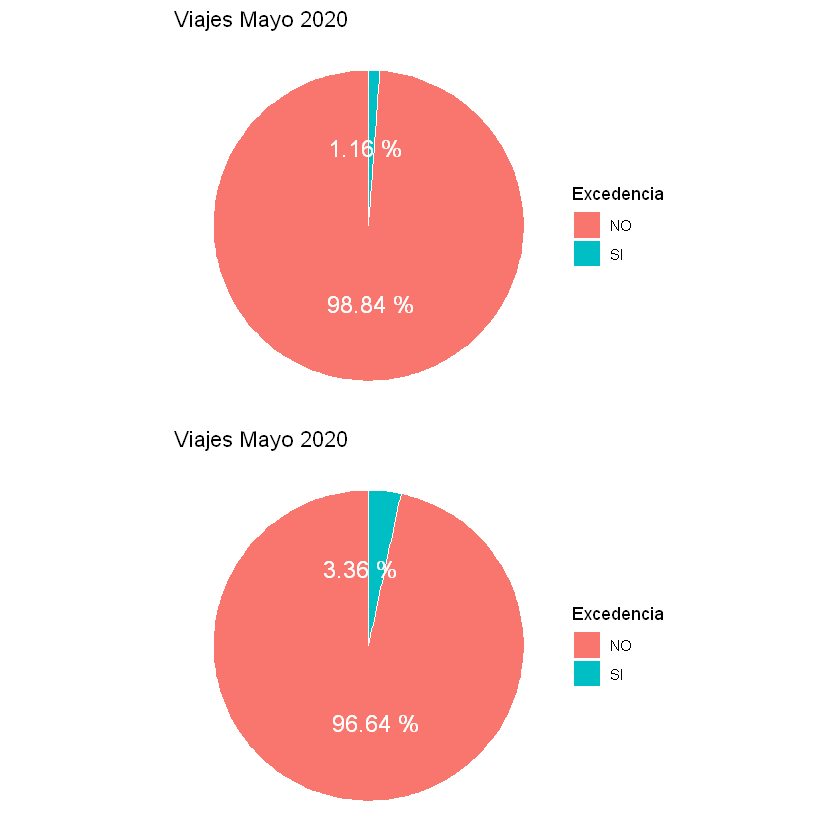

In [184]:
Exc19 = Mayo19 %>% group_by(Excedencia) %>% summarise(count=n(),.groups = "drop") %>% mutate(prop=round(100*count/dim(Mayo19)[1],2),lab.ypos = cumsum(prop) - 0.5*prop)
exc19=ggplot(Exc19, aes(x = "", y = prop, fill = Excedencia)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  geom_text(aes(y = lab.ypos, label = paste(prop,"%")), color = "white",size=5)+  theme_void() + ggtitle("Viajes Mayo 2020")
Exc20 = Mayo20 %>% group_by(Excedencia) %>% summarise(count=n(),.groups = "drop") %>% mutate(prop=round(100*count/dim(Mayo20)[1],2),lab.ypos = cumsum(prop) - 0.5*prop)
exc20=ggplot(Exc20, aes(x = "", y = prop, fill = Excedencia)) +
  geom_bar(width = 1, stat = "identity", color = "white") +
  coord_polar("y", start = 0)+
  geom_text(aes(y = lab.ypos, label = paste(prop,"%")), color = "white",size=5)+  theme_void() + ggtitle("Viajes Mayo 2020")
grid.arrange(exc19,exc20)

Visualmente se puede corroborar que la proporción de viajes mayores a 45 minutos fue mayor en Mayo 2020.

En `R` se puede emplear la función `prop.test` para llevar a cabo la prueba para igualdad de proporciones de excedencia en el tiempo de viaje, de una cola, para contrastar las siguientes hipótesis:

$$
H_0: \quad p_{2019} \geq p_{2020} \qquad \text{vs} \qquad H_1: \quad p_{2019} < p_{2020}
$$

la cual funciona con base en el Teorema de Límite Central, y emplea el estadístico de prueba

$$
Z=\dfrac{\hat{p}_{2019}-\hat{p}_{2020}}{\sqrt{\hat{p}(1-\hat{p})\left(\dfrac{1}{n_{2019}}+\dfrac{1}{n_{2020}} \right)   }}
$$

donde $\hat{p}_{2019}$ y $\hat{p}_{2020}$ son las proporcines de excedencia de 45 minutos por viaje en Mayo 2019 y Mayo 2020 respectivamente, $n_{2019}$ y $n_{2020}$ son los tamaños de muestra, y $\hat{p}$ está dado por

$$
\hat{p}=\dfrac{n_{2019}\hat{p}_{2019}+n_{2020}\hat{p}_{2020}}{n_{2019}+n_{2020}}
$$


In [188]:
prop.test(x = c(sum((Mayo19$Excedencia=="SI")*1), sum((Mayo20$Excedencia=="SI")*1)), n = c(length(Mayo19$Excedencia), length(Mayo20$Excedencia)),alternative = "less")


	2-sample test for equality of proportions with continuity correction

data:  c(sum((Mayo19$Excedencia == "SI") * 1), sum((Mayo20$Excedencia ==  out of c(length(Mayo19$Excedencia), length(Mayo20$Excedencia))    "SI") * 1)) out of c(length(Mayo19$Excedencia), length(Mayo20$Excedencia))
X-squared = 4071.3, df = 1, p-value < 2.2e-16
alternative hypothesis: less
95 percent confidence interval:
 -1.00000000 -0.02122885
sample estimates:
    prop 1     prop 2 
0.01161006 0.03362835 


La hipótesis nula se rechaza en favor de la hipótesis alternativa al nivel 0.05 de significancia. Se concluye que los datos aportan evidencia estadísticamente significativa de que la proporción de viajes irregulares en Mayo 2020 es mayor que en Mayo 2019.